# Predict Bitcoin Price

In [1]:
!pip install pandas-datareader

In [2]:
!pip install tensorflow

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import pandas_datareader as web 
import datetime as dt 

from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Dense, Dropout, LSTM 
from tensorflow.keras.models import Sequential

C:\Users\A\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\A\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\A\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Variable initialization

In [4]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [5]:
#Prepare Data
print(data.head())

                  High         Low        Open       Close    Volume  \
Date                                                                   
2015-12-31  432.920990  418.734985  425.875000  430.566986  45996600   
2016-01-01  436.246002  427.515015  430.721008  434.334015  36278900   
2016-01-02  436.062012  431.869995  434.622009  433.437988  30096600   
2016-01-03  433.743011  424.705994  433.578003  430.010986  39633800   
2016-01-04  434.516998  429.084015  430.061005  433.091003  38477500   

             Adj Close  
Date                    
2015-12-31  430.566986  
2016-01-01  434.334015  
2016-01-02  433.437988  
2016-01-03  430.010986  
2016-01-04  433.091003  


In [6]:
#Reset the Index 
data = data.reset_index(drop=True)
data

,High,Low,Open,Close,Volume,Adj Close
0,432.920990,418.734985,425.875000,430.566986,45996600,430.566986
1,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
3,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
4,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
...,...,...,...,...,...,...
2355,28502.685547,26762.648438,28373.513672,26762.648438,34163220274,26762.648438
2356,26795.589844,22141.257812,26737.578125,22487.388672,68204556440,22487.388672
2357,23018.951172,20950.818359,22487.986328,22206.792969,50913575242,22206.792969
2358,22642.671875,20178.376953,22196.730469,22572.839844,54912007015,22572.839844


In [7]:
data.iloc[1:60, 3].mean()

407.22579645706435

In [8]:
#Write a function for baseline(Adjusted Moving Average). If volatility is high, moving average over a long period might not take the recent fluctuating 
#trend into account, so smav(slow moving average) might be good base for predicting the price in the period of high volatility. In this case,
#fast moving average, that over short period(well-cover recent period), could be good base, so fmav should be more significant than smav 
#when computing the baseline for the prediction. Otherwise, in the period of low volatility, fmav could rather be worse candidate for being baseline than smav because
#fmav is not generalized. 
def baseline(dataset, start_index, end_index):
    baseline = [] 
    smav = dataset.iloc[start_index:end_index, 3].mean()
    fmav = dataset.iloc[start_index+(prediction_days-5):end_index, 3].mean()
    var = dataset.iloc[start_index:end_index, 3].std() / (dataset.iloc[start_index:end_index, 3].max() - dataset.iloc[start_index:end_index, 3].min())
    adj_mav = (1/var) * smav + var * fmav
     
    return adj_mav
    
    

In [9]:
#Calculate Baseline
prediction_days = 80
baselines_train = []
for i in range(len(data)-prediction_days): 
    baselines_train.append(baseline(data, i, i+prediction_days)) 
baselines_train = np.array(baselines_train)

In [10]:
len(baselines_train)

2280

In [11]:
baselines_train

array([  1717.67515484,   1723.71556426,   1732.79968623, ...,
       145799.26326346, 143580.13352905, 141251.28363333])

In [12]:
data

,High,Low,Open,Close,Volume,Adj Close
0,432.920990,418.734985,425.875000,430.566986,45996600,430.566986
1,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
3,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
4,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
...,...,...,...,...,...,...
2355,28502.685547,26762.648438,28373.513672,26762.648438,34163220274,26762.648438
2356,26795.589844,22141.257812,26737.578125,22487.388672,68204556440,22487.388672
2357,23018.951172,20950.818359,22487.986328,22206.792969,50913575242,22206.792969
2358,22642.671875,20178.376953,22196.730469,22572.839844,54912007015,22572.839844


In [13]:
#Prepare Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_baselines = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_baselines = scaler_baselines.fit_transform(baselines_train.reshape(-1, 1))

In [14]:
#Make training dataset
x_train, y_train = [], []
arr_index_count = 0
for x in range(prediction_days, len(scaled_data)): 
    x_train.append(scaled_data[x-prediction_days:x, 0])
    x_train[arr_index_count] = np.append(x_train[arr_index_count], scaled_baselines[x-prediction_days, 0])
    y_train.append(scaled_data[x, 0])
    arr_index_count = arr_index_count + 1
#Scale 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
x_train.shape

(2280, 81, 1)

In [16]:
y_train.shape

(2280,)

In [22]:
#Create LSTM Model 
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adagrad, RMSprop, Nadam, Adam

In [18]:
price_model = Sequential()
price_model.add(LSTM(units=prediction_days-10, return_sequences=True,input_shape=(x_train.shape[1], 1)))
price_model.add(Dropout(0.2))
price_model.add(LSTM(units=prediction_days-10, return_sequences=True))
price_model.add(Dropout(0.2))
price_model.add(LSTM(units=prediction_days-20))
price_model.add(Dropout(0.2))
price_model.add(Dense(units=1))
opt = Nadam(learning_rate=0.0008)
price_model.compile(optimizer=opt, loss='mean_squared_error')
price_model.fit(x_train, y_train, epochs=80, batch_size=32, callbacks = EarlyStopping(monitor='loss',patience=8, restore_best_weights=True))

Epoch 1/80
72/72 [==============================] - 10s 67ms/step - loss: 0.0069
Epoch 2/80
72/72 [==============================] - 5s 67ms/step - loss: 0.0029
Epoch 3/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0026
Epoch 4/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0022
Epoch 5/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0020
Epoch 6/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0020
Epoch 7/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0017
Epoch 8/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0020
Epoch 9/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0018
Epoch 10/80
72/72 [==============================] - 5s 66ms/step - loss: 0.0014
Epoch 11/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0015
Epoch 12/80
72/72 [==============================] - 5s 65ms/step - loss: 0.0014
Epoch 13/80
72/72 [=================

In [19]:
price_model_2 = Sequential()
price_model_2.add(LSTM(units=prediction_days, return_sequences=True,input_shape=(x_train.shape[1], 1)))
price_model_2.add(Dropout(0.1))
price_model_2.add(LSTM(units=prediction_days, return_sequences=True))
price_model_2.add(Dropout(0.1))
price_model_2.add(LSTM(units=prediction_days))
price_model_2.add(Dropout(0.1))
price_model_2.add(Dense(units=10))
price_model_2.add(Dense(units=1))
opt = Nadam(learning_rate=0.01)
price_model_2.compile(optimizer=opt, loss='mean_squared_error')
price_model_2.fit(x_train, y_train, epochs=80, batch_size=32, callbacks = EarlyStopping(monitor='loss',patience=8, restore_best_weights=True))

Epoch 1/80
72/72 [==============================] - 11s 80ms/step - loss: 0.1275
Epoch 2/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0024
Epoch 3/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0025
Epoch 4/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0015
Epoch 5/80
72/72 [==============================] - 6s 80ms/step - loss: 0.0016
Epoch 6/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0014
Epoch 7/80
72/72 [==============================] - 6s 81ms/step - loss: 0.0015
Epoch 8/80
72/72 [==============================] - 6s 81ms/step - loss: 0.0016
Epoch 9/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0011
Epoch 10/80
72/72 [==============================] - 6s 81ms/step - loss: 0.0011
Epoch 11/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0011
Epoch 12/80
72/72 [==============================] - 6s 79ms/step - loss: 0.0012
Epoch 13/80
72/72 [=================

In [30]:
price_model_3 = Sequential()
price_model_3.add(LSTM(units=prediction_days+10, return_sequences=True,input_shape=(x_train.shape[1], 1)))
price_model_3.add(Dropout(0.1))
price_model_3.add(LSTM(units=prediction_days+20, return_sequences=True))
price_model_3.add(Dropout(0.1))
price_model_3.add(LSTM(units=prediction_days+20, return_sequences=True))
price_model_3.add(Dropout(0.1))
price_model_3.add(LSTM(units=prediction_days+10))
price_model_3.add(Dropout(0.1))
price_model_3.add(Dense(units=1))
opt = Adam(learning_rate=0.008)
price_model_3.compile(optimizer=opt, loss='mean_squared_error')
price_model_3.fit(x_train, y_train, epochs=80, batch_size=32, callbacks = EarlyStopping(monitor='loss',patience=8, restore_best_weights=True))

Epoch 1/80
72/72 [==============================] - 15s 112ms/step - loss: 0.0159
Epoch 2/80
72/72 [==============================] - 8s 116ms/step - loss: 0.0015
Epoch 3/80
72/72 [==============================] - 9s 124ms/step - loss: 0.0018
Epoch 4/80
72/72 [==============================] - 8s 112ms/step - loss: 0.0022
Epoch 5/80
72/72 [==============================] - 8s 117ms/step - loss: 0.0016
Epoch 6/80
72/72 [==============================] - 8s 113ms/step - loss: 8.4937e-04
Epoch 7/80
72/72 [==============================] - 8s 111ms/step - loss: 8.1245e-04
Epoch 8/80
72/72 [==============================] - 8s 111ms/step - loss: 0.0011
Epoch 9/80
72/72 [==============================] - 8s 112ms/step - loss: 9.7111e-04
Epoch 10/80
72/72 [==============================] - 8s 114ms/step - loss: 8.5497e-04
Epoch 11/80
72/72 [==============================] - 8s 115ms/step - loss: 8.3531e-04
Epoch 12/80
72/72 [==============================] - 8s 117ms/step - loss: 8.5312e-04


In [65]:
#Create Ensemble Model 
train_pred_1 = price_model.predict(x_train)
train_pred_2 = price_model_2.predict(x_train)
train_pred_3 = price_model_3.predict(x_train)
train_pred = np.concatenate((train_pred_1, train_pred_2, train_pred_3), axis=1)
Ensemble = Sequential()
Ensemble.add(Dense(units=3, input_shape=(train_pred.shape[1],)))
Ensemble.add(Dense(units=1))
Ensemble.compile(optimizer='Adam', loss='mean_squared_error')
Ensemble.fit(train_pred, y_train, epochs=50, batch_size=32, callbacks=EarlyStopping(monitor='loss', patience=10, restore_best_weights=True))


72/72 [==============================] - 3s 37ms/step
Epoch 1/50
72/72 [==============================] - 0s 741us/step - loss: 0.0537
Epoch 2/50
72/72 [==============================] - 0s 757us/step - loss: 0.0126
Epoch 3/50
72/72 [==============================] - 0s 805us/step - loss: 0.0041
Epoch 4/50
72/72 [==============================] - 0s 857us/step - loss: 0.0012
Epoch 5/50
72/72 [==============================] - 0s 801us/step - loss: 6.1602e-04
Epoch 6/50
72/72 [==============================] - 0s 689us/step - loss: 5.4390e-04
Epoch 7/50
72/72 [==============================] - 0s 749us/step - loss: 5.3924e-04
Epoch 8/50
72/72 [==============================] - 0s 748us/step - loss: 5.3699e-04
Epoch 9/50
72/72 [==============================] - 0s 738us/step - loss: 5.3866e-04
Epoch 10/50
72/72 [==============================] - 0s 781us/step - loss: 5.3646e-04
Epoch 11/50
72/72 [==============================] - 0s 749us/step - loss: 5.3688e-04
Epoch 12/50
72/72 [======

In [66]:
pred = Ensemble.predict(train_pred)
pred.shape

72/72 [==============================] - 0s 592us/step


(2280, 1)

In [64]:
y_train.shape

(2280,)

In [43]:
test_start = dt.datetime(2021
                         ,1,1)
test_end = dt.datetime.now()

In [44]:
test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
total_dataset = pd.concat((data, test_data), axis=0)
actual_prices = test_data['Close'].values 
total_data_prices = total_dataset['Close'].values

In [34]:
actual_prices

array([29001.72070312, 29374.15234375, 32127.26757812, 32782.0234375 ,
       31971.9140625 , 33992.4296875 , 36824.36328125, 39371.04296875,
       40797.609375  , 40254.546875  , 38356.44140625, 35566.65625   ,
       33922.9609375 , 37316.359375  , 39187.328125  , 36825.3671875 ,
       36178.140625  , 35791.27734375, 36630.07421875, 36069.8046875 ,
       35547.75      , 30825.69921875, 33005.76171875, 32067.64257812,
       32289.37890625, 32366.39257812, 32569.84960938, 30432.546875  ,
       33466.09765625, 34316.38671875, 34269.5234375 , 33114.359375  ,
       33537.17578125, 35510.2890625 , 37472.08984375, 36926.06640625,
       38144.30859375, 39266.01171875, 38903.44140625, 46196.46484375,
       46481.10546875, 44918.18359375, 47909.33203125, 47504.8515625 ,
       47105.515625  , 48717.2890625 , 47945.05859375, 49199.87109375,
       52149.0078125 , 51679.796875  , 55888.1328125 , 56099.51953125,
       57539.9453125 , 54207.3203125 , 48824.42578125, 49705.33203125,
      

In [35]:
baselines_test = []
for i in range(len(total_dataset)-prediction_days): 
    baselines_test.append(baseline(total_dataset, i, i+prediction_days))
baselines_test = np.array(baselines_test)

In [36]:
model_inputs = total_dataset.iloc[len(total_dataset)-len(test_data)-prediction_days:, 3].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [37]:
baselines_test = baselines_test.reshape(-1, 1)
scaled_baselines = scaler_baselines.fit_transform(baselines_test) 

In [38]:
scaled_baselines

array([[4.43567244e-04],
       [4.63245868e-04],
       [4.92840389e-04],
       ...,
       [4.69836823e-01],
       [4.62607277e-01],
       [4.55020281e-01]])

In [39]:
x_test = []
arr_index_count = 0
for x in range(prediction_days, len(model_inputs)): 
    x_test.append(model_inputs[x-prediction_days:x, 0])
    x_test[arr_index_count] = np.append(x_test[arr_index_count], scaled_baselines[x, 0])
    arr_index_count = arr_index_count + 1
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [40]:
x_test.shape

(533, 81, 1)

In [68]:
prediction_prices_1 = price_model.predict(x_test)
prediction_prices_2 = price_model_2.predict(x_test)
prediction_prices_3 = price_model_3.predict(x_test)
prediction_prices = np.concatenate((prediction_prices_1, prediction_prices_2, prediction_prices_3), axis=1)
prediction = Ensemble.predict(prediction_prices)
print(prediction_prices.shape)
prediction = scaler.inverse_transform(prediction)

17/17 [==============================] - 0s 625us/step
(533, 3)


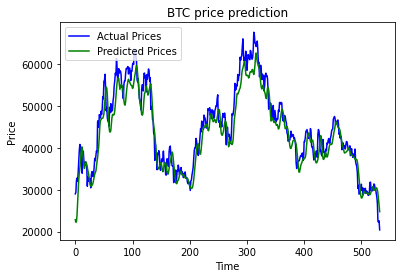

In [69]:
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(prediction, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [30]:
prediction_prices.shape

(531, 81, 1)